In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use("seaborn-v0_8-whitegrid")

from scipy.stats import gaussian_kde

In [4]:
class Data_description(object):
    '''
    '''
    def __init__(self, df, label_ind = None, label_name = None):
        self.df = df
        self.n_features = len(df.columns) - 1 # 라벨 벡터가 하나겠죠..?
        self.n_samples = df.shape[0]

        if type(label_ind) == int:
            self.label_ind = label_ind
        elif type(label_name) == str:
            self.label_ind = self.df.columns.get_loc(label_name)

        self.label_value = np.unique(self.df.iloc[:, self.label_ind])

        label_ratio = np.zeros(shape = len(self.label_value), dtype = float)
        for i, label in enumerate(self.label_value):
            label_ratio[i] = np.sum(np.where(self.df.iloc[:,self.label_ind] == label, 1, 0)) / self.n_samples
        self.label_ratio = label_ratio

    
    def describe(self, quantile = [0.25, 0.5, 0.75]):
        df = self.df.drop(self.df.columns[self.label_ind], axis = 1)

        self.count = df.count()
        self.nan_count = df.isna().sum(axis =0)
        
        self.mean = df.mean(axis = 0) 
        self.variance = df.var(axis = 0)
        self.median = df.median()
        self.max = df.max()
        self.min = df.min()
        self.range = self.max - self.min
        
        self.quantile = df.quantile(q = quantile, )
        quantile_names = [f"Quantile[{str(i*100)}%]" for i in quantile]
        self.quantile.index = quantile_names
        
        self.describe_df = pd.concat([pd.DataFrame({'count': self.count,
                                        'Na_count': self.nan_count,
                                        'mean': self.mean,
                                        'variance': self.variance,
                                        'median': self.median,
                                        'max': self.max,
                                        'min': self.min,
                                        'range': self.range}), self.quantile.T], axis = 1)

        return self.describe_df

    
    # 이산형(Discrete)인지 연속형(Continuous)인지 판단
    def infer_variable_type(self, unique_val_ratio = 0.05):
        df = self.df.drop(self.df.columns[self.label_ind], axis = 1)
        self.variable_type = np.empty(shape = self.n_features, dtype = object)

        for i in range(self.n_features):
            if len(np.unique(df.iloc[:, i])) / len(df.iloc[:, i]) < unique_val_ratio:
                self.variable_type[i] = "Discrete"
            else: 
                self.variable_type[i] = "Continuous"
        return self.variable_type

    
    def kde(self, standard_scale = False, min_max_scale = False, figsize = (5,4), h = 1000, color_list = ["red", "blue", "green", "orange", "purple"],
            cmap = 'viridis'):
        
        df = self.df.drop(self.df.columns[self.label_ind], axis = 1)

        method = None
        if standard_scale == True:
            df = (df - df.mean(axis = 0)) / np.sqrt(df.var(axis = 0))
            method = "Standard"
        
        if min_max_scale == True:
            df = (df - df.min()) / (df.max() - df.min())
            method = "Min_Max"
        

        self.kde_arr = np.empty(shape = self.n_features, dtype = object)
        for ind, feature in enumerate(df.columns):
            self.kde_arr[ind] = gaussian_kde(dataset = df[feature])
            
        plt.figure(figsize = figsize)
        x = np.linspace(start = df.min().min() - 1, stop = df.max().max() + 1, num = h)

        if self.n_features <= len(color_list):
            for i in range(self.n_features):
                plt.plot(x, self.kde_arr[i](x), color = color_list[i], alpha = 0.5, label = df.columns[i])
        else: 
            cmap_ = plt.get_cmap(cmap)
            for i in range(self.n_features):
                cmap_color = cmap_(i / self.n_features)
                plt.plot(x, self.kde_arr[i](x), color = cmap_color, alpha = 0.5, label = df.columns[i])
            
        plt.legend(loc = "upper right")
        plt.title(f"KDE[scaled = {method}]")
        plt.show()

    
    def hist(self, bins, layout, figsize):
        df = self.df.drop(self.df.columns[self.label_ind], axis = 1)
        df.hist(bins = bins, layout = layout, figsize = figsize, color = "gray")
        plt.show()

    
    def scatter(self, figsize, subplot_nrow, subplot_ncol, color_list = ["red", "blue", "green", "orange", "purple"]):
        df = self.df.drop(self.df.columns[self.label_ind], axis = 1)

        plt.figure(figsize = figsize)
        subplot_ind = 1
        for i in range(self.n_features):
            for j in range(i+1, self.n_features):
                plt.subplot(subplot_nrow, subplot_ncol, subplot_ind)
                
                for ind, label in enumerate(self.label_value):
                    cond = (self.df.iloc[:, self.label_ind] == label)
                    plt.scatter(x = df.loc[cond, df.columns[i]], y = df.loc[cond, df.columns[j]], s = 10, c = color_list[ind], 
                                label = f"label[{label}]", alpha = 0.5)

                
                plt.xlabel(df.columns[i])
                plt.ylabel(df.columns[j])
                plt.legend(loc = "upper right")

                subplot_ind += 1
        plt.tight_layout()
        plt.show()
    
    def cov_matrix(self):
        X = np.array(self.df.drop(self.df.columns[self.label_ind], axis = 1))
        X_tilde = X - np.mean(a = X, axis = 0)

        cov_matrix = np.empty(shape = (self.n_features, self.n_features), dtype = float)
        for i in range(self.n_features):
            for j in range(i, self.n_features):
                cov_matrix[i,j] = np.mean(X_tilde[:,i] * X_tilde[:,j])
                if i != j:
                    cov_matrix[j,i] = cov_matrix[i,j]
        return cov_matrix

    
    def corr_matrix(self):
        X = np.array(self.df.drop(self.df.columns[self.label_ind], axis = 1))
        X_tilde = X - np.mean(a = X, axis = 0)

        cov_matrix = np.empty(shape = (self.n_features, self.n_features), dtype = float)
        for i in range(self.n_features):
            for j in range(i, self.n_features):
                cov_matrix[i,j] = np.mean(X_tilde[:,i] * X_tilde[:,j]) / (np.std(X_tilde[:,i]) * np.std(X_tilde[:,j]))
                if i != j:
                    cov_matrix[j,i] = cov_matrix[i,j]
        return cov_matrix

In [7]:
file_path = r"C:\Users\user\Downloads\dataset\car.dat"

car_df = pd.read_csv(file_path, sep = "\t", header = None)
car_df # 마지막 인덱스가 레이블이겠지?

,0,1,2,3,4,5,6
0,4,4,2,2,0,0,1
1,4,4,2,2,0,1,1
2,4,4,2,2,0,2,1
3,4,4,2,2,1,0,1
4,4,4,2,2,1,1,1
...,...,...,...,...,...,...,...
1723,1,1,0,3,1,1,3
1724,1,1,0,3,1,2,4
1725,1,1,0,3,2,0,1
1726,1,1,0,3,2,1,3


In [9]:
car_df.columns = ("feature1", "feature2", "feature3", "feature4", "feature5","feature6", "label")
car_df.head(n = 10)

,feature1,feature2,feature3,feature4,feature5,feature6,label
0,4,4,2,2,0,0,1
1,4,4,2,2,0,1,1
2,4,4,2,2,0,2,1
3,4,4,2,2,1,0,1
4,4,4,2,2,1,1,1
5,4,4,2,2,1,2,1
6,4,4,2,2,2,0,1
7,4,4,2,2,2,1,1
8,4,4,2,2,2,2,1
9,4,4,2,4,0,0,1


In [12]:
car_discribe = Data_description(df = car_df, label_name = "label")

In [14]:
print(f"car데이터 셋의 샘플 개수: {car_discribe.n_samples}")
print(f"car데이터 셋의 유니크한 라벨 값: {car_discribe.label_value}")
print(f"car데이터 셋의 라벨 비율: {car_discribe.label_ratio}")
print(f"car데이터 셋 특징 자료형: {car_discribe.infer_variable_type()}")

car데이터 셋의 샘플 개수: 1728
car데이터 셋의 유니크한 라벨 값: [1 2 3 4]
car데이터 셋의 라벨 비율: [0.70023148 0.22222222 0.03993056 0.03761574]
car데이터 셋 특징 자료형: ['Discrete' 'Discrete' 'Discrete' 'Discrete' 'Discrete' 'Discrete']


In [16]:
car_discribe.describe()

,count,Na_count,mean,variance,median,max,min,range,Quantile[25.0%],Quantile[50.0%],Quantile[75.0%]
feature1,1728,0,2.50,1.250724,2.5,4,1,3,1.75,2.5,3.25
feature2,1728,0,2.50,1.250724,2.5,4,1,3,1.75,2.5,3.25
feature3,1728,0,2.25,2.188767,2.5,4,0,4,1.50,2.5,3.25
feature4,1728,0,3.00,0.667053,3.0,4,2,2,2.00,3.0,4.00
feature5,1728,0,1.00,0.667053,1.0,2,0,2,0.00,1.0,2.00
feature6,1728,0,1.00,0.667053,1.0,2,0,2,0.00,1.0,2.00


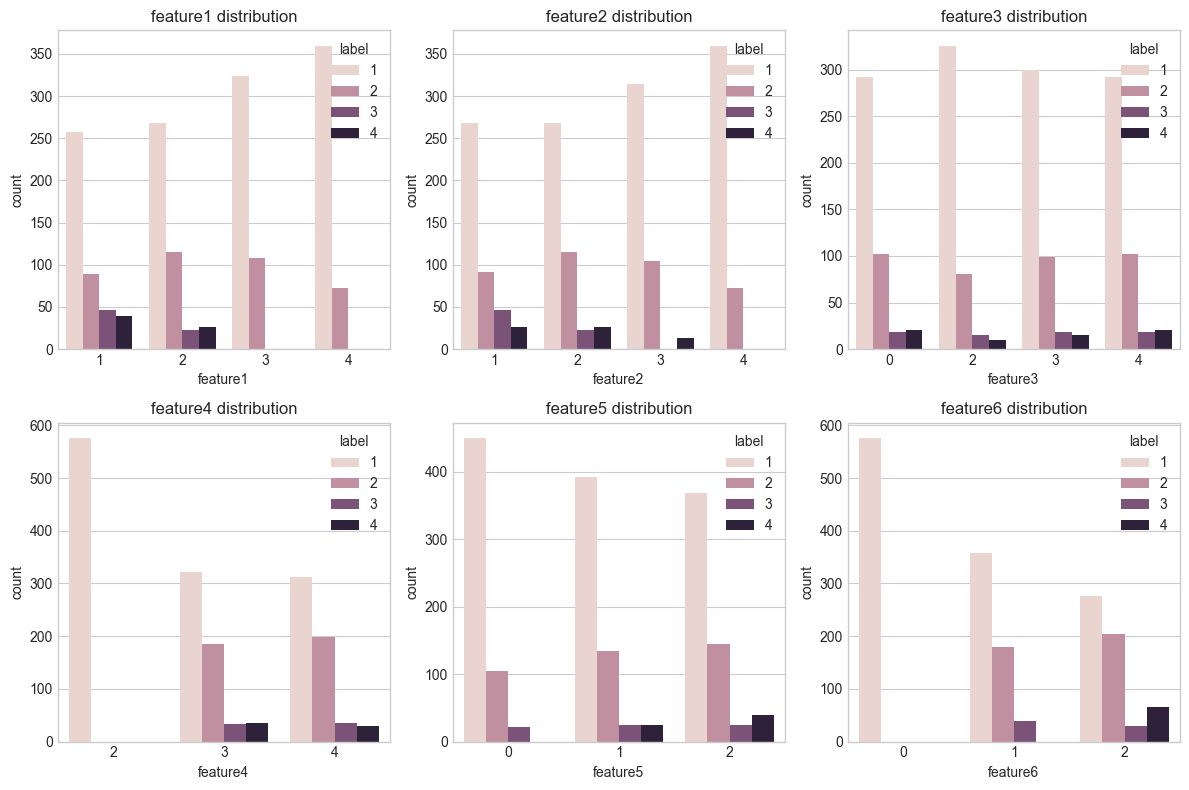

In [19]:
import seaborn as sns

plt.figure(figsize=(12,8)) 
for ind, col in enumerate(car_df.columns[:-1]): 
    plt.subplot(2, 3, ind+1)
    sns.countplot(data=car_df, x=col, hue="label")
    plt.title(f"{col} distribution")

plt.tight_layout()
plt.show()

In [25]:
m = pd.crosstab(index = car_df["feature1"], columns = car_df["label"]); m

label,1,2,3,4
feature1,,,,
1,258,89,46,39
2,268,115,23,26
3,324,108,0,0
4,360,72,0,0


In [46]:
# 카이제곱 독립성 검정
from scipy.stats import chi2

def chi_indepence_test(df, index, columns):
    cross_table = pd.crosstab(index = df[index], columns = df[columns])
    O = cross_table.values
    degree_of_freedom = (O.shape[0] - 1) * (O.shape[1] - 1)

    O_colsum = np.sum(O, axis = 0)
    O_rowsum = np.sum(O, axis = 1)
    E = np.outer(O_rowsum, O_colsum) / O.sum()
    
    chi_val = np.sum((O - E)**2 / E)
    p_value = 1 - chi2.cdf(chi_val, df=degree_of_freedom)
    
    return p_value

In [72]:
chi_square_pval_matrix = np.zeros(shape = len(car_df.columns[:-1]), dtype = float)

for i, feature in enumerate(car_df.columns[:-1]):
    chi_square_pval_matrix[i] = chi_indepence_test(df = car_df, index = feature, columns = "label")
    
chi_square_pval_matrix.round(decimals = 4) # feature3만 귀무가설 기각x => 독립

array([0.    , 0.    , 0.3202, 0.    , 0.    , 0.    ])